In [230]:
import pandas as pd
import numpy as np
from joblib import dump, load
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.linear_model import ElasticNet, LinearRegression, LogisticRegression

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Bidirectional, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import SGD, Adam
from keras.wrappers.scikit_learn import KerasRegressor

from datetime import datetime

import re

from nltk.corpus import stopwords

import spacy
from spacy.lang.en.stop_words import STOP_WORDS

import language_check
from string import punctuation

from gensim.models.word2vec import Word2Vec
import string

import en_core_web_sm
nlp = en_core_web_sm.load()
stopwords = stopwords.words('english')

In [88]:
# kappa metric for measuring agreement of automatic to human scores
from sklearn.metrics import cohen_kappa_score, confusion_matrix

def kappa(y_true, y_pred, weights=None, allow_off_by_one=False):
    """
    Calculates the kappa inter-rater agreement between two the gold standard
    and the predicted ratings. Potential values range from -1 (representing
    complete disagreement) to 1 (representing complete agreement).  A kappa
    value of 0 is expected if all agreement is due to chance.
    In the course of calculating kappa, all items in ``y_true`` and ``y_pred`` will
    first be converted to floats and then rounded to integers.
    It is assumed that y_true and y_pred contain the complete range of possible
    ratings.
    This function contains a combination of code from yorchopolis's kappa-stats
    and Ben Hamner's Metrics projects on Github.
    Parameters
    ----------
    y_true : array-like of float
        The true/actual/gold labels for the data.
    y_pred : array-like of float
        The predicted/observed labels for the data.
    weights : str or np.array, optional
        Specifies the weight matrix for the calculation.
        Options are ::
            -  None = unweighted-kappa
            -  'quadratic' = quadratic-weighted kappa
            -  'linear' = linear-weighted kappa
            -  two-dimensional numpy array = a custom matrix of
        weights. Each weight corresponds to the
        :math:`w_{ij}` values in the wikipedia description
        of how to calculate weighted Cohen's kappa.
        Defaults to None.
    allow_off_by_one : bool, optional
        If true, ratings that are off by one are counted as
        equal, and all other differences are reduced by
        one. For example, 1 and 2 will be considered to be
        equal, whereas 1 and 3 will have a difference of 1
        for when building the weights matrix.
        Defaults to False.
    Returns
    -------
    k : float
        The kappa score, or weighted kappa score.
    Raises
    ------
    AssertionError
        If ``y_true`` != ``y_pred``.
    ValueError
        If labels cannot be converted to int.
    ValueError
        If invalid weight scheme.
    """

    # Ensure that the lists are both the same length
    assert(len(y_true) == len(y_pred))

    # This rather crazy looking typecast is intended to work as follows:
    # If an input is an int, the operations will have no effect.
    # If it is a float, it will be rounded and then converted to an int
    # because the ml_metrics package requires ints.
    # If it is a str like "1", then it will be converted to a (rounded) int.
    # If it is a str that can't be typecast, then the user is
    # given a hopefully useful error message.
    try:
        y_true = [int(np.round(float(y))) for y in y_true]
        y_pred = [int(np.round(float(y))) for y in y_pred]
    except ValueError:
        raise ValueError("For kappa, the labels should be integers or strings "
                         "that can be converted to ints (E.g., '4.0' or '3').")

    # Figure out normalized expected values
    min_rating = min(min(y_true), min(y_pred))
    max_rating = max(max(y_true), max(y_pred))

    # shift the values so that the lowest value is 0
    # (to support scales that include negative values)
    y_true = [y - min_rating for y in y_true]
    y_pred = [y - min_rating for y in y_pred]

    # Build the observed/confusion matrix
    num_ratings = max_rating - min_rating + 1
    observed = confusion_matrix(y_true, y_pred,
                                labels=list(range(num_ratings)))
    num_scored_items = float(len(y_true))

    # Build weight array if weren't passed one
    if isinstance(weights, str):
        wt_scheme = weights
        weights = None
    else:
        wt_scheme = ''
    if weights is None:
        weights = np.empty((num_ratings, num_ratings))
        for i in range(num_ratings):
            for j in range(num_ratings):
                diff = abs(i - j)
                if allow_off_by_one and diff:
                    diff -= 1
                if wt_scheme == 'linear':
                    weights[i, j] = diff
                elif wt_scheme == 'quadratic':
                    weights[i, j] = diff ** 2
                elif not wt_scheme:  # unweighted
                    weights[i, j] = bool(diff)
                else:
                    raise ValueError('Invalid weight scheme specified for '
                                     'kappa: {}'.format(wt_scheme))

    hist_true = np.bincount(y_true, minlength=num_ratings)
    hist_true = hist_true[: num_ratings] / num_scored_items
    hist_pred = np.bincount(y_pred, minlength=num_ratings)
    hist_pred = hist_pred[: num_ratings] / num_scored_items
    expected = np.outer(hist_true, hist_pred)

    # Normalize observed array
    observed = observed / num_scored_items

    # If all weights are zero, that means no disagreements matter.
    k = 1.0
    if np.count_nonzero(weights):
        k -= (sum(sum(weights * observed)) / sum(sum(weights * expected)))

    return k

In [89]:
essay_sets = pd.read_pickle('training_features.pkl')

In [90]:
all_features = [  
                'word_count',
                'corrections',
                'similarity',
                'token_count',
                'unique_token_count',
                'nostop_count',
                'sent_count',
                'ner_count',
                'comma',
                'question',
                'exclamation',
                'quotation',
                'organization',
                'caps',
                'person',
                'location',
                'money',
                'time',
                'date',
                'percent',
                'noun',
                'adj',
                'pron',
                'verb',
                'cconj',
                'adv',
                'det',
                'propn',
                'num',
                'part',
                'intj',
                ]

In [91]:
essay_sets[all_features]

,word_count,corrections,similarity,token_count,unique_token_count,nostop_count,sent_count,ner_count,comma,question,...,adj,pron,verb,cconj,adv,det,propn,num,part,intj
0,338,11,0.953891,396,181,204,19,3,18,2,...,18,36,51,14,18,32,5,0,16,2
1,419,19,0.954198,456,206,237,23,12,14,1,...,23,35,83,18,26,45,7,5,10,1
2,279,9,0.951935,305,162,153,23,5,9,0,...,19,20,40,16,13,32,1,3,10,0
3,524,35,0.966408,579,266,332,35,15,14,1,...,41,21,80,17,25,55,29,0,24,2
4,465,17,0.955189,516,211,252,30,6,13,0,...,27,30,80,16,40,60,3,3,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12971,845,15,0.925195,954,347,449,51,41,50,0,...,41,125,134,55,76,79,32,16,24,5
12972,546,41,0.957361,644,230,329,55,24,22,10,...,37,67,82,28,54,64,12,5,17,5
12973,817,23,0.952395,954,381,513,52,29,47,7,...,38,68,122,39,64,112,36,5,21,5
12974,562,13,0.969016,666,258,355,44,10,40,2,...,44,77,78,22,62,67,11,4,10,1


In [92]:
def correct_language(df):
    """
    use language tool to correct for most spelling and grammatical errors. Also count the applied corrections. 
    Using language_check python wrapper for languagetool:
    https://www.languagetool.org/dev
    """
    tool = language_check.LanguageTool('en-US')

    df['matches'] = df['essay'].apply(lambda txt: tool.check(txt))
    df['corrections'] = df.apply(lambda l: len(l['matches']), axis=1)
    df['corrected'] = df.apply(lambda l: language_check.correct(l['essay'], l['matches']), axis=1)
      
    return df

In [93]:
training_set = pd.read_pickle('training_corr.pkl')

In [94]:
training_set.head()

,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,...,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6,word_count,matches,corrections,corrected
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,338,"[Line 1, column 219, Rule ID: MORFOLOGIK_RULE_...",11,"Dear local newspaper, I think effects computer..."
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,419,"[Line 1, column 149, Rule ID: MORFOLOGIK_RULE_...",19,"Dear @CAPS1 @CAPS2, I believe that using compu..."
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,279,"[Line 1, column 316, Rule ID: MORFOLOGIK_RULE_...",9,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl..."
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,524,"[Line 1, column 87, Rule ID: MORFOLOGIK_RULE_E...",35,"Dear Local Newspaper, @CAPS1 I have found that..."
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,465,"[Line 1, column 178, Rule ID: MORFOLOGIK_RULE_...",17,"Dear @LOCATION1, I know having computers has a..."


In [95]:
# read essays from validation and test sets

valid_set  = pd.read_csv('valid_set.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic'})
test_set  = pd.read_csv('test_set.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic'})

combo_set = pd.concat([valid_set, test_set], sort=False)

# apply spelling and grammar corrections
combo_set = correct_language(combo_set)

In [96]:
# save work
combo_set = pd.concat([combo_set, training_set], sort=False)
combo_set.to_pickle('combo_corr.pkl')

In [97]:
len(combo_set)

21448

In [98]:
# Clean training_set essays before feeding them to the Word2Vec model.
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_essays(essays, logging=False):
    texts = []
    counter = 1
    for essay in essays.corrected:
        if counter % 2000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(essays)))
        counter += 1
        essay = nlp(essay, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in essay if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [100]:
# Define function to preprocess text for a word2vec model
def cleanup_essay_word2vec(essays, logging=False):
    sentences = []
    counter = 1
    for essay in essays:
        if counter % 2000 == 0 and logging:
            print("Processed %d out of %d documents" % (counter, len(essays)))
        # Disable tagger so that lemma_ of personal pronouns (I, me, etc) don't getted marked as "-PRON-"
        essay = nlp(essay, disable=['tagger'])
        # Grab lemmatized form of words and make lowercase
        essay = " ".join([tok.lemma_.lower() for tok in essay])
        # Split into sentences based on punctuation
        essay = re.split("[\.?!;] ", essay)
        # Remove commas, periods, and other punctuation (mostly commas)
        essay = [re.sub("[\.,;:!?]", "", sent) for sent in essay]
        # Split into words
        essay = [sent.split() for sent in essay]
        sentences += essay
        counter += 1
    return sentences

In [103]:
# Define function to create averaged word vectors given a cleaned text.
def create_average_vec(essay):
    average = np.zeros((text_dim,), dtype='float32')
    num_words = 0.
    for word in essay.split():
        if word in wordvec_model.wv.vocab:
            average = np.add(average, wordvec_model.wv[word])
            num_words += 1.
    if num_words != 0.:
        average = np.divide(average, num_words)
    return average

In [104]:
# Create word vectors
cleaned_vec = np.zeros((training_set.shape[0], text_dim), dtype="float32")  
for i in range(len(train_cleaned)):
    cleaned_vec[i] = create_average_vec(train_cleaned[i])

print("Word vectors for all essays in the training data set are of shape:", cleaned_vec.shape)

Word vectors for all essays in the training data set are of shape: (12976, 300)


In [193]:
# Read generated features from file:
additional_features = pd.read_pickle('training_features.pkl')
additional_features = additional_features[all_features]

stdscaler = StandardScaler()
additional_features = stdscaler.fit_transform(additional_features)
additional_features.shape

(12976, 31)

In [194]:
# Combine topic number, target score, additional features and cleaned word vectors
all_data = pd.concat([training_set[['topic','target_score']], pd.DataFrame(additional_features), pd.DataFrame(cleaned_vec)], axis=1)
all_data.shape

(12976, 333)

In [204]:
# DataFrame used to pass original values through train_test_split
scores = all_data[['topic', 'target_score']].reset_index() 

# Rescale target_score (essay grades) in range 0 - 60:
scaler = MinMaxScaler((0,10))

# Use this for classification:
# ohe = OneHotEncoder(n_values=61)

In [205]:
# Rescale and assign target variable y
scaled = []
for topic in range(1,9):
    topic_scores = scores[scores['topic'] == topic]['target_score'].to_frame()
    s = (scaler.fit_transform(topic_scores).reshape(-1))
    scaled = np.append(scaled, s)
    
scores['scaled'] = scaled

y = scores['scaled'].to_frame()

# Features
X = all_data.drop(['topic', 'target_score'], axis=1)

In [238]:
X

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.655391,0.051903,0.945351,0.734578,0.884732,0.735680,0.268343,-0.308862,1.082567,0.472610,...,0.046690,-0.054332,-0.025974,0.077837,0.079077,0.047589,-0.034476,0.086002,-0.059922,-0.025840
1,1.115846,0.882094,0.950630,1.035800,1.237953,1.058519,0.565679,1.389517,0.654665,0.117715,...,0.021736,-0.037031,-0.002432,0.107631,0.092594,0.042493,-0.016558,0.038885,-0.038564,-0.009765
2,0.319998,-0.155645,0.911656,0.277725,0.616284,0.236748,0.565679,0.068555,0.119787,-0.237180,...,0.033406,-0.033021,-0.041394,0.098643,0.081354,0.078695,-0.006532,0.042729,-0.073114,-0.038604
3,1.712732,2.542476,1.160873,1.653306,2.085683,1.987904,1.457685,1.955644,0.654665,0.117715,...,0.024600,-0.028838,-0.030575,0.159531,0.087229,0.023749,-0.011115,0.045944,-0.005873,-0.002987
4,1.377339,0.674546,0.967692,1.337022,1.308597,1.205264,1.086016,0.257264,0.547689,-0.237180,...,0.056353,-0.046832,-0.019275,0.080815,0.078522,0.054827,-0.026959,0.031899,-0.064273,-0.036088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12971,3.537497,0.466998,0.451239,3.535944,3.230120,3.132514,2.647027,6.862074,4.505785,-0.237180,...,0.042949,-0.073589,-0.018053,0.097129,0.078758,0.015181,-0.057102,-0.003525,-0.021958,-0.013842
12972,1.837793,3.165119,1.005092,1.979630,1.577045,1.958555,2.944362,3.654024,1.510469,3.311773,...,0.058817,-0.065430,-0.014795,0.089937,0.090771,0.032938,-0.069852,0.000100,-0.051981,-0.037306
12973,3.378327,1.297190,0.919577,3.535944,3.710500,3.758626,2.721361,4.597568,4.184858,2.247087,...,0.015994,-0.108182,-0.010828,0.136442,0.080772,-0.033636,-0.082205,-0.011040,-0.011085,-0.001069
12974,1.928747,0.259451,1.205787,2.090078,1.972653,2.212912,2.126690,1.012100,3.436029,0.472610,...,0.011672,-0.084001,-0.018170,0.122151,0.092824,-0.011221,-0.054780,-0.009830,-0.028426,-0.034520


In [207]:
# Data to be split
X_train, X_test, y_train, y_test, scores_train, scores_test = \
        train_test_split(
                X, 
                y, 
                scores,
                test_size=0.2, 
                random_state=26
                )

print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_test size: {}'.format(y_test.shape))
print('scores_train size: {}'.format(scores_train.shape))
print('scores_test size: {}'.format(scores_test.shape))

X_train size: (10380, 331)
X_test size: (2596, 331)
y_train size: (10380, 1)
y_test size: (2596, 1)
scores_train size: (10380, 4)
scores_test size: (2596, 4)


In [208]:
output_dim = y.shape[1]
input_dim = X.shape[1]
dropout = 0.2

def build_model(architecture='mlp'):
    model = Sequential()
    if architecture == 'mlp':
        # Densely Connected Neural Network (Multi-Layer Perceptron)
        model.add(Dense(14, activation='relu', kernel_initializer='he_normal', input_dim=input_dim)) 
        model.add(Dropout(dropout))
        model.add(Dense(output_dim))
    else:
        print('Error: Model type not found.')
        
    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer=adam, loss='mse', metrics=['mse','mae'])
    return model

In [209]:
# Define keras model
mlp_model = None

# Using MLP in kernel for speed
mlp_model = build_model('mlp')

mlp_model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 14)                4648      
_________________________________________________________________
dropout_22 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 15        
Total params: 4,663
Trainable params: 4,663
Non-trainable params: 0
_________________________________________________________________


In [211]:
t0 = datetime.now()

# Define number of epochs
epochs = 100

# Fit the model to the training data
mlp_model.fit(X_train, y_train, epochs=epochs, batch_size=15, verbose=0)

# Save model
model_name = mlp_model.name + '_model'
mlp_model.save(model_name)

# Predict and evaluate kappa
y_pred = pd.DataFrame(mlp_model.predict(X_test).reshape(-1))
print('kappa = ', kappa(y_pred.values, y_test.values, weights='quadratic'))

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))
print(' ')                  

INFO:tensorflow:Assets written to: sequential_30_model\assets
kappa =  0.7418508156572994
Processing time: 0:00:26.379105
 


In [225]:
y_pred = mlp_model.predict(X_test[11:13])

y_pred

array([[5.681938]], dtype=float32)

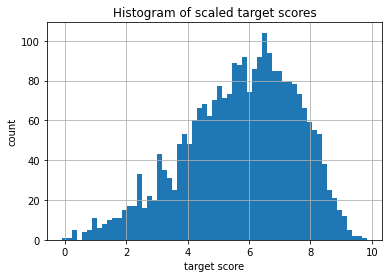

In [226]:
y_pred_frame = pd.DataFrame(mlp_model.predict(X_test).reshape(-1))

y_pred_frame.hist(bins=61)
plt.title('Histogram of scaled target scores')
plt.xlabel('target score')
plt.ylabel('count')
plt.savefig('image6.png', dpi=300)
plt.show()

In [227]:
import random

reference_essays = {1: 161, 2: 3022, 3: 5263, 4: 5341, 5: 7209, 6: 8896, 7: 11796, 8: 12340} # topic: essay_id

references = {}

stop_words = set(STOP_WORDS)

# generate nlp object for reference essays:
for topic, index in reference_essays.items():
    references[topic] = nlp(essay_sets.iloc[index]['essay'])


def avg_similarity(essay):
    sim = 0
    
    for ref in references:
        sim += nlp(essay).similarity(references[ref])
    
    return sim / 8

In [242]:
def extract_features(essay_text):
    d = {'essay': [essay_text]}
    essay_data = pd.DataFrame(data=d)
    
    essay_data['word_count'] = essay_data['essay'].str.strip().str.split().str.len()
    
    tool = language_check.LanguageTool('en-US')

    essay_data['matches'] = essay_data['essay'].apply(lambda txt: tool.check(txt))
    essay_data['corrections'] = essay_data.apply(lambda l: len(l['matches']), axis=1)
    essay_data['corrected'] = essay_data.apply(lambda l: language_check.correct(l['essay'], l['matches']), axis=1)
    
    sents = []
    tokens = []
    lemma = []
    pos = []
    ner = []

    stop_words = set(STOP_WORDS)
    stop_words.update(punctuation)

    nlp = en_core_web_sm.load()

    np.warnings.filterwarnings('ignore')

    for essay in nlp.pipe(essay_data['corrected']):
        tokens.append([e.text for e in essay])
        sents.append([sent.string.strip() for sent in essay.sents])
        pos.append([e.pos_ for e in essay])
        ner.append([e.text for e in essay.ents])
        lemma.append([n.lemma_ for n in essay])

    essay_data['tokens'] = tokens
    essay_data['lemma'] = lemma
    essay_data['pos'] = pos
    essay_data['sents'] = sents
    essay_data['ner'] = ner
    
    essay_data['similarity'] = essay_data.apply(lambda row: avg_similarity(row['essay']), axis=1)
    
    essay_data['token_count'] = essay_data.apply(lambda x: len(x['tokens']), axis=1)
    essay_data['unique_token_count'] = essay_data.apply(lambda x: len(set(x['tokens'])), axis=1)
    essay_data['nostop_count'] = essay_data \
            .apply(lambda x: len([token for token in x['tokens'] if token not in stop_words]), axis=1)
    essay_data['sent_count'] = essay_data.apply(lambda x: len(x['sents']), axis=1)
    essay_data['ner_count'] = essay_data.apply(lambda x: len(x['ner']), axis=1)
    essay_data['comma'] = essay_data.apply(lambda x: x['corrected'].count(','), axis=1)
    essay_data['question'] = essay_data.apply(lambda x: x['corrected'].count('?'), axis=1)
    essay_data['exclamation'] = essay_data.apply(lambda x: x['corrected'].count('!'), axis=1)
    essay_data['quotation'] = essay_data.apply(lambda x: x['corrected'].count('"') + x['corrected'].count("'"), axis=1)
    essay_data['organization'] = essay_data.apply(lambda x: x['corrected'].count(r'@ORGANIZATION'), axis=1)
    essay_data['caps'] = essay_data.apply(lambda x: x['corrected'].count(r'@CAPS'), axis=1)
    essay_data['person'] = essay_data.apply(lambda x: x['corrected'].count(r'@PERSON'), axis=1)
    essay_data['location'] = essay_data.apply(lambda x: x['corrected'].count(r'@LOCATION'), axis=1)
    essay_data['money'] = essay_data.apply(lambda x: x['corrected'].count(r'@MONEY'), axis=1)
    essay_data['time'] = essay_data.apply(lambda x: x['corrected'].count(r'@TIME'), axis=1)
    essay_data['date'] = essay_data.apply(lambda x: x['corrected'].count(r'@DATE'), axis=1)
    essay_data['percent'] = essay_data.apply(lambda x: x['corrected'].count(r'@PERCENT'), axis=1)
    essay_data['noun'] = essay_data.apply(lambda x: x['pos'].count('NOUN'), axis=1)
    essay_data['adj'] = essay_data.apply(lambda x: x['pos'].count('ADJ'), axis=1)
    essay_data['pron'] = essay_data.apply(lambda x: x['pos'].count('PRON'), axis=1)
    essay_data['verb'] = essay_data.apply(lambda x: x['pos'].count('VERB'), axis=1)
    essay_data['noun'] = essay_data.apply(lambda x: x['pos'].count('NOUN'), axis=1)
    essay_data['cconj'] = essay_data.apply(lambda x: x['pos'].count('CCONJ'), axis=1)
    essay_data['adv'] = essay_data.apply(lambda x: x['pos'].count('ADV'), axis=1)
    essay_data['det'] = essay_data.apply(lambda x: x['pos'].count('DET'), axis=1)
    essay_data['propn'] = essay_data.apply(lambda x: x['pos'].count('PROPN'), axis=1)
    essay_data['num'] = essay_data.apply(lambda x: x['pos'].count('NUM'), axis=1)
    essay_data['part'] = essay_data.apply(lambda x: x['pos'].count('PART'), axis=1)
    essay_data['intj'] = essay_data.apply(lambda x: x['pos'].count('INTJ'), axis=1)

    return essay_data

In [308]:
def essay_data_to_vec(essay_data):
    essay_cleaned = cleanup_essays(essay_data, logging=False)
    
    cleaned_vec = np.zeros((essay_cleaned.shape[0], text_dim), dtype="float32")  
    for i in range(len(essay_cleaned)):
        cleaned_vec[i] = create_average_vec(essay_cleaned[i])
        
    return cleaned_vec

In [231]:
reconstructed_model = keras.models.load_model("sequential_30_model")

reconstructed_model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 14)                4648      
_________________________________________________________________
dropout_22 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 15        
Total params: 4,663
Trainable params: 4,663
Non-trainable params: 0
_________________________________________________________________


In [412]:
import cv2
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'H:\Tesseract\tesseract.exe'

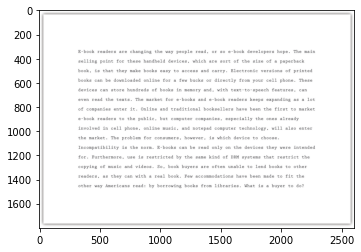

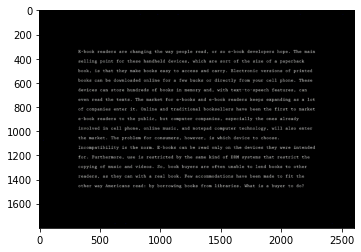

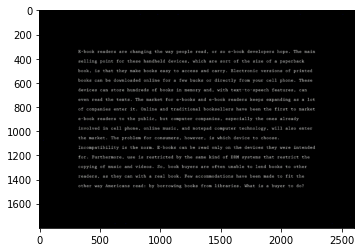

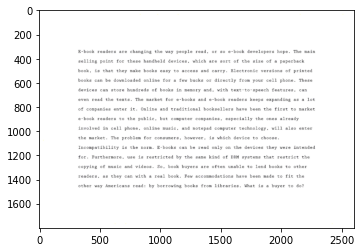

E-book readers are changing the way people read, or so e-book developers hope. The main
selling point for these handheld devices, which are sort of the size of a paperback
book, is that they make books easy to access and carry. Electronic versions of printed
books can be downloaded online for a few bucks or directly from your cell phone. These
devices can store hundreds of books in memory and, with text-to-speech features, can
even read the texts. The market for e-books and e-book readers keeps expanding as a lot
of companies enter it. Online and traditional booksellers have been the first to market
e-book readers to the public, but computer companies, especially the ones already
involved in cell phone, online music, and notepad computer technology, will also enter
the market. The problem for consumers, however, is which device to choose.
Incompatibility is the norm. E-books can be read only on the devices they were intended
for. Furthermore, use is restricted by the same kind of DRM s

In [416]:
image = cv2.imread("images/essay.jpg")
plt.imshow(image)
plt.show()

thresh = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY_INV)[1]
plt.imshow(thresh)
plt.show()

result = cv2.GaussianBlur(thresh, (5,5), 0)
plt.imshow(result)
plt.show()

result = 255 - result
plt.imshow(result)
plt.show()

data = pytesseract.image_to_string(result, lang='eng',config='--psm 6')
print(data)

In [394]:
def predict_score(essay_text):
    essay = extract_features(essay_text)
    additional_essay_features = essay[all_features]
    
    additional_features = pd.read_pickle('training_features.pkl')
    additional_features = pd.concat([additional_features[all_features], additional_essay_features], ignore_index=True)

    stdscaler = StandardScaler()
    additional_features = stdscaler.fit_transform(additional_features)
        
    essay_scaled = additional_features[-1]

    cleaned_vec = essay_data_to_vec(essay)
    
    all_essay_data = pd.concat([pd.DataFrame(additional_features), pd.DataFrame(cleaned_vec)], axis=1)
    score_pred = reconstructed_model.predict(all_essay_data[0:1])
    
    return score_pred[0][0]

In [404]:
predict_score(data)

5.847556